In [1]:
import os
import glob
import zipfile
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LinearRegression
from dask.distributed import Client

/home/kingpin/anaconda3/envs/mldl/lib/python3.10/site-packages/optuna/study/_optimize.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
# ==============================================
# 🚀 1. Start Dask Client (Connect to Scheduler)
# ==============================================
client = Client('tcp://192.168.0.103:8786')  # Updated your local laptop IP
print(client)


   

<Client: 'tcp://192.168.0.103:8786' processes=2 threads=16, memory=29.08 GiB>


In [3]:
print("📂 Checking Kaggle Weather Events data...")

# Use environment variable or fallback to default
nfs_mount = os.environ.get("nfs_mount_path", "/home/kingpin/nfs_shared")
csv_path = os.path.join(nfs_mount, "WeatherEvents_Jan2016-Dec2022.csv")

# Now load the CSV
print(f"📂 Loading {csv_path} with Dask...")
df = dd.read_csv(csv_path, assume_missing=True,blocksize="64MB")
df = df.persist()
print("✅ Columns available:", df.columns)
print(df.head())

📂 Checking Kaggle Weather Events data...
📂 Loading /home/kingpin/nfs_shared/WeatherEvents_Jan2016-Dec2022.csv with Dask...
✅ Columns available: Index(['EventId', 'Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)',
       'Precipitation(in)', 'TimeZone', 'AirportCode', 'LocationLat',
       'LocationLng', 'City', 'County', 'State', 'ZipCode'],
      dtype='object')
  EventId  Type Severity       StartTime(UTC)         EndTime(UTC)  \
0     W-1  Snow    Light  2016-01-06 23:14:00  2016-01-07 00:34:00   
1     W-2  Snow    Light  2016-01-07 04:14:00  2016-01-07 04:54:00   
2     W-3  Snow    Light  2016-01-07 05:54:00  2016-01-07 15:34:00   
3     W-4  Snow    Light  2016-01-08 05:34:00  2016-01-08 05:54:00   
4     W-5  Snow    Light  2016-01-08 13:54:00  2016-01-08 15:54:00   

   Precipitation(in)     TimeZone AirportCode  LocationLat  LocationLng  \
0               0.00  US/Mountain        K04V      38.0972    -106.1689   
1               0.00  US/Mountain        K04V      38.0972  

In [4]:
# ==============================================
# 🔎 2.1 Inspect Dataset Columns and Basic Info
# ==============================================
print("✅ Columns available:")
print(df.columns)

print("\n🧹 Basic Dataset Info:")
print(df.dtypes)



✅ Columns available:
Index(['EventId', 'Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)',
       'Precipitation(in)', 'TimeZone', 'AirportCode', 'LocationLat',
       'LocationLng', 'City', 'County', 'State', 'ZipCode'],
      dtype='object')

🧹 Basic Dataset Info:
EventId              string[pyarrow]
Type                 string[pyarrow]
Severity             string[pyarrow]
StartTime(UTC)       string[pyarrow]
EndTime(UTC)         string[pyarrow]
Precipitation(in)            float64
TimeZone             string[pyarrow]
AirportCode          string[pyarrow]
LocationLat                  float64
LocationLng                  float64
City                 string[pyarrow]
County               string[pyarrow]
State                string[pyarrow]
ZipCode                      float64
dtype: object


In [5]:
# ==============================================
#  BASIC PREPROCESSING
# ==============================================
print("🛠️ Starting FULL bulletproof preprocessing...")

import dask.dataframe as dd

# 1. Parse datetime
print("📅 Parsing StartTime(UTC) as datetime...")
df['StartTime(UTC)'] = dd.to_datetime(df['StartTime(UTC)'], errors='coerce')

# 2. Extract year
print("Extracting Year from StartTime...")
df['Year'] = df['StartTime(UTC)'].dt.year




# 3. Categorize string columns properly
categorical_columns = ['Type', 'Severity', 'State']
print(f"🏷️ Categorizing columns: {categorical_columns}...")
df = df.categorize(columns=categorical_columns)

# 4. Create category code columns
print("🏷️ Creating categorical code columns...")
for col in categorical_columns:
    df[col + '_Code'] = df[col].cat.codes

# 5. Drop rows where Precipitation(in) is missing
print("Dropping missing Precipitation rows...")
df = df.dropna(subset=['Precipitation(in)'])

'''# 6. Materialize FULL df now to avoid lazy Categorize errors
print("Materializing full DataFrame after preprocessing...")
df = df.compute()

# 7. Rebuild fresh Dask DataFrame for further processing
print(" Rebuilding as fresh Dask DataFrame...")
df = dd.from_pandas(df, npartitions=8)'''


# 6. Persist the preprocessed graph (better than compute!)
print("🧠 Persisting final preprocessed DataFrame to memory...")
df = df.persist()

print("FULL Basic Preprocessing Complete!")


🛠️ Starting FULL bulletproof preprocessing...
📅 Parsing StartTime(UTC) as datetime...
Extracting Year from StartTime...
🏷️ Categorizing columns: ['Type', 'Severity', 'State']...
🏷️ Creating categorical code columns...
Dropping missing Precipitation rows...
🧠 Persisting final preprocessed DataFrame to memory...
FULL Basic Preprocessing Complete!


In [6]:
# ==============================================
# 📊 4. Prepare Features (X) and Target (y)
# ==============================================
print(" Preparing feature matrix and target vector...")

# Define features and target
features = ['Type_Code', 'Severity_Code', 'State_Code', 'Year', 'LocationLat', 'LocationLng']
target = 'Precipitation(in)'

# Select
X = df[features]
y = df[target]

print(" Features and target ready!")
print(f"Features: {X.columns.tolist()}")
print(f"Target: {target}")


 Preparing feature matrix and target vector...
 Features and target ready!
Features: ['Type_Code', 'Severity_Code', 'State_Code', 'Year', 'LocationLat', 'LocationLng']
Target: Precipitation(in)


In [7]:
# ==============================================
# ✂️ 5. Train-Test Split
# ==============================================
print("✂️ Splitting into train and test sets...")

from dask_ml.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Train-test split done!")
print(f"Train size: {len(X_train)} samples")
print(f"Test size: {len(X_test)} samples")


✂️ Splitting into train and test sets...
✅ Train-test split done!


/home/kingpin/anaconda3/envs/mldl/lib/python3.10/site-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


Train size: 6901125 samples
Test size: 1726056 samples


In [8]:
# ==============================================
# 🔎 Check Dask Workers Status (Clean Version)
# ==============================================
print("🔎 Checking Dask workers...")

workers_info = client.scheduler_info()["workers"]

if not workers_info:
    print("❌ No workers found! (Something wrong — restart Dask cluster.)")
else:
    print(f"✅ {len(workers_info)} workers connected.")
    for addr, info in workers_info.items():
        print(f"  • Worker: {addr}")
        print(f"    - CPU cores : {info['nthreads']}")
        print(f"    - Memory GB : {round(info['memory_limit'] / 1e9, 2)} GB")


🔎 Checking Dask workers...
✅ 2 workers connected.
  • Worker: tcp://192.168.0.103:44869
    - CPU cores : 8
    - Memory GB : 16.68 GB
  • Worker: tcp://192.168.0.106:44635
    - CPU cores : 8
    - Memory GB : 14.55 GB


In [9]:
# ==============================================
# ♻️ Rebalance Data Across Dask Workers
# ==============================================
print("♻️ Rebalancing data across workers...")

client.rebalance()

print("✅ Rebalancing complete!")


♻️ Rebalancing data across workers...
✅ Rebalancing complete!


In [10]:
client.rebalance([X_train, y_train])


In [11]:
# ==============================================
# 🎯 6. Train Distributed Linear Regression
# ==============================================
print("🎯 Training distributed Linear Regression model...")

from dask_ml.linear_model import LinearRegression

# Create model
lr = LinearRegression()

# ⭐ Important: Dask-ML expects Dask Arrays, not Dask DataFrames
X_train_array = X_train.to_dask_array(lengths=True)
y_train_array = y_train.to_dask_array(lengths=True)

# Train
lr.fit(X_train_array, y_train_array)

print("✅ Model training complete!")


🎯 Training distributed Linear Regression model...
✅ Model training complete!


In [12]:
# ==============================================
# 🔄 Convert Train/Test Dask DataFrames to Dask Arrays
# ==============================================
print("🔄 Converting Train/Test DataFrames to Arrays...")

X_train_array = X_train.to_dask_array(lengths=True)
X_test_array = X_test.to_dask_array(lengths=True)
y_train_array = y_train.to_dask_array(lengths=True)
y_test_array = y_test.to_dask_array(lengths=True)

print("✅ Conversion complete!")

🔄 Converting Train/Test DataFrames to Arrays...
✅ Conversion complete!


In [13]:
# ==============================================
# 📊 Save Train Graph before Prediction
# ==============================================
print("📊 Visualizing Training Graph...")

# Visualize the trained model's prediction setup
# (Since lr.fit() has completed, now visualize X_test preparation)
X_train_array.visualize(filename="graphs/X_test_array_graph", format="png", rankdir="LR")

print("✅ Train/Train Graph saved!")


📊 Visualizing Training Graph...
✅ Train/Train Graph saved!


In [14]:
# ==============================================
# 📊 Save Train Graph before Prediction
# ==============================================
print("📊 Visualizing Training Graph...")

# Visualize the trained model's prediction setup
# (Since lr.fit() has completed, now visualize X_test preparation)
X_test_array.visualize(filename="graphs/X_test_array_graph", format="png", rankdir="LR")

print("✅ Train/Test Graph saved!")


📊 Visualizing Training Graph...
✅ Train/Test Graph saved!


In [15]:
# ==============================================
# 📈 7. Predict + Evaluate
# ==============================================
print("📈 Starting distributed predictions...")

# Distributed Prediction
y_pred = lr.predict(X_test_array)

# ⭐ (Optional) Visualize Prediction Task Graph
#y_pred.visualize(filename="graphs/prediction_graph", format="png", rankdir="LR")

# ==============================================
# 🧹 7.1 Compute Predictions and Ground Truth
# ==============================================
print("🧹 Computing predictions and actuals...")

y_test_computed = y_test_array.compute()
y_pred_computed = y_pred.compute()

# ==============================================
# 📉 7.2 Mean Absolute Error (MAE) Evaluation
# ==============================================
print("📉 Evaluating prediction performance...")

mae = np.mean(np.abs(y_test_computed - y_pred_computed))
print(f"✅ Mean Absolute Error (MAE): {mae:.4f} inches Precipitation")


📈 Starting distributed predictions...
🧹 Computing predictions and actuals...
📉 Evaluating prediction performance...
✅ Mean Absolute Error (MAE): 0.1364 inches Precipitation


📈 Plotting Actual vs Predicted Scatter Plot...


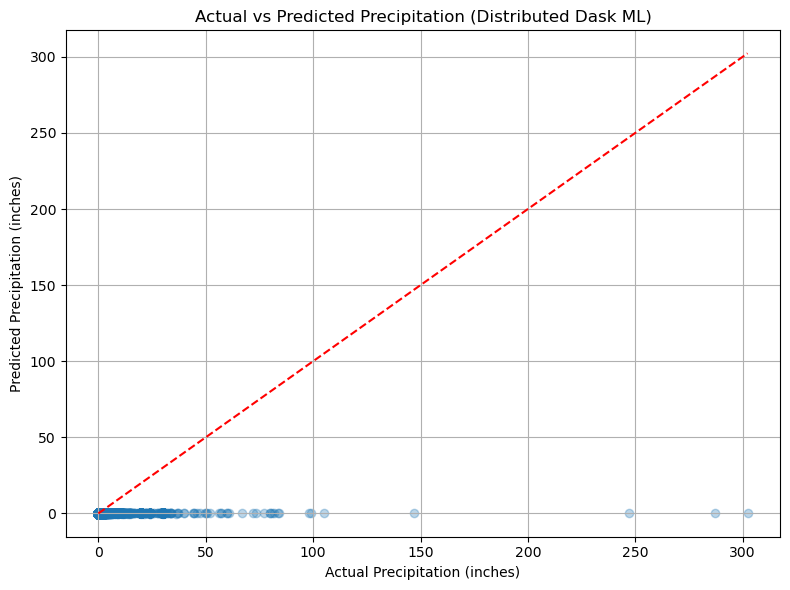

✅ Plot saved as graphs/actual_vs_predicted.png


In [16]:
# ==============================================
# 📈 8. Plot Actual vs Predicted
# ==============================================
print("📈 Plotting Actual vs Predicted Scatter Plot...")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_computed, y_pred_computed, alpha=0.3)
plt.plot([0, max(y_test_computed.max(), y_pred_computed.max())], 
         [0, max(y_test_computed.max(), y_pred_computed.max())], 
         'r--')
plt.xlabel('Actual Precipitation (inches)')
plt.ylabel('Predicted Precipitation (inches)')
plt.title('Actual vs Predicted Precipitation (Distributed Dask ML)')
plt.grid(True)
plt.tight_layout()
plt.savefig("graphs/actual_vs_predicted.png")
plt.show()

print("✅ Plot saved as graphs/actual_vs_predicted.png")
